In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
from data.bt_dataset import BrainTumorDataset
from model import BrainTumorCNN
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
import torch
import os
import cv2
from train import train
from evaluate import evaluate
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
    print("Working on: GPU")
    device = 'cuda'
else:
    print("Working on: CPU")
    device = 'cpu'

Working on: GPU


### Defining constants:

In [4]:
IMAGE_SIZE = 256
NUM_OF_CLASSES = 4
train_batch_size = test_batch_size = 64
dataset_path = os.path.join(os.getcwd(), os.path.join('data', 'dataset'))

### Preprocessing:

In [5]:
# Resizing the images and normalizing them then, sharpening them:
image_preprocessing = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.transforms.Normalize((0.1794, 0.1794, 0.1794), (0.1884, 0.1884, 0.1884)),
                                        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                        lambda image : transforms.functional.adjust_sharpness(image, sharpness_factor=2)
])

### Defining the dataset:

In [6]:
# Defining the Dataset object:
demo_dataset = BrainTumorDataset(dataset_path=dataset_path, preprocessing=None)
dataset = BrainTumorDataset(dataset_path=dataset_path, preprocessing=image_preprocessing)

## Splitting the dataset into training, validation and testing datasets:

In [7]:
train_size = int(0.6 * len(dataset))
validation_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - validation_size


train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size + test_size])
validation_dataset, test_dataset = torch.utils.data.random_split(validation_dataset, [validation_size, test_size])

print(f'Train set size: {train_size}\nValidation set size: {validation_size}\nTest set size: {test_size}')

Train set size: 1958
Validation set size: 652
Test set size: 654


In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=train_batch_size, shuffle=True)

## Dataset distribution:

In [9]:
dataset.get_data_distribution()

{'pituitary_tumor': 901,
 'glioma_tumor': 926,
 'meningioma_tumor': 937,
 'no_tumor': 500}

### Plotting a sample image

In [10]:
pre_processed_img = dataset[650][0]
original_image = demo_dataset[650][0]

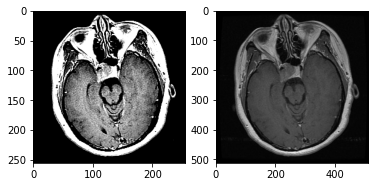

In [11]:
f, axarr = plt.subplots(1,2)

axarr[0].imshow(pre_processed_img.permute(1, 2, 0))
axarr[1].imshow(original_image.permute(0, 1, 2))

### Model specifications:

In [12]:
model = BrainTumorCNN(number_of_classes=NUM_OF_CLASSES, image_size=IMAGE_SIZE)

parameters = model.parameters()
learning_rate = 5e-4
weight_decay = 2e-8
momentum = 0.9

# Getting the class weights to apply weighted loss:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(parameters, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
# optimizer = torch.optim.Adam(parameters, lr=learning_rate, weight_decay=weight_decay)

In [13]:
scheduler = StepLR(optimizer, step_size=5, gamma=2)

In [14]:
sample_size = 10
overfitting_set = []
class_indicies_distrib = dataset.class_indicies_distribution()
for i in class_indicies_distrib:
    overfitting_set += class_indicies_distrib[i][:10]

## Overfitting the model in order to test if it can learn

In [15]:
overfitting_subset = Subset(dataset, overfitting_set)
overfitting_loader = DataLoader(overfitting_subset)

In [16]:
epochs = 10

In [17]:
scheduler = None
total_loss, epoch_times, accuracies_train, _ = train(model=model, train_loader=overfitting_loader,
                                                                   validation_loader=overfitting_loader, optimizer=optimizer,
                                                                   criterion=criterion, epochs=epochs, scheduler=scheduler)

100%|██████████| 40/40 [00:01<00:00, 27.82it/s]

Evaluating epoch...


Epoch: 0 | Loss: 201.23 | Runtime: 3.03 seconds


100%|██████████| 40/40 [00:01<00:00, 29.85it/s]

Evaluating epoch...


Epoch: 1 | Loss: 115.71 | Runtime: 2.02 seconds


100%|██████████| 40/40 [00:00<00:00, 67.98it/s] 

Evaluating epoch...


Epoch: 2 | Loss: 124.04 | Runtime: 1.23 seconds


100%|██████████| 40/40 [00:00<00:00, 102.13it/s]

Evaluating epoch...


Epoch: 3 | Loss: 72.35 | Runtime: 1.37 seconds


100%|██████████| 40/40 [00:00<00:00, 110.79it/s]

Evaluating epoch...


Epoch: 4 | Loss: 59.09 | Runtime: 1.01 seconds


100%|██████████| 40/40 [00:00<00:00, 48.14it/s]

Evaluating epoch...


Epoch: 5 | Loss: 47.72 | Runtime: 1.44 seconds


100%|██████████| 40/40 [00:00<00:00, 55.58it/s] 

Evaluating epoch...


Epoch: 6 | Loss: 42.41 | Runtime: 1.50 seconds


100%|██████████| 40/40 [00:00<00:00, 43.02it/s]

Evaluating epoch...


Epoch: 7 | Loss: 36.89 | Runtime: 1.65 seconds


100%|██████████| 40/40 [00:00<00:00, 98.72it/s] 

Evaluating epoch...


Epoch: 8 | Loss: 31.51 | Runtime: 1.12 seconds


100%|██████████| 40/40 [00:00<00:00, 97.03it/s]

Evaluating epoch...


Epoch: 9 | Loss: 26.92 | Runtime: 1.02 seconds


### Plotting the loss:

In [18]:
import matplotlib.pyplot as plt

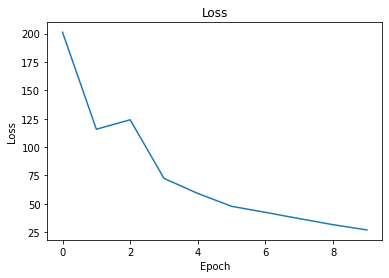

In [19]:
plt.title("Loss") 

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(total_loss)
plt.show()

### Plotting train accuracy:

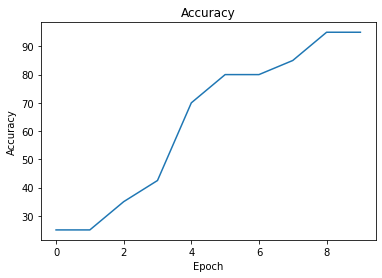

In [20]:
plt.title("Accuracy") 

plt.xlabel("Epoch")
plt.ylabel("Accuracy")


plt.plot(accuracies_train)
plt.show()

In [21]:
accuracy = evaluate(model=model, test_loader=overfitting_loader)
print(f'Overfitting Accuracy: {accuracy:.2f}%')

Overfitting Accuracy: 95.00%


## Creating the model to train it on the actual data:

In [23]:
model = BrainTumorCNN(number_of_classes=NUM_OF_CLASSES, image_size=IMAGE_SIZE)

parameters = model.parameters()
learning_rate = 1e-3
weight_decay = 2e-4
momentum = 0.9

# Getting the class weights to apply weighted loss:
class_weights = torch.tensor(dataset.class_weights).float().to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = torch.optim.SGD(parameters, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

### Training the model

In [25]:
epochs = 50

In [26]:
scheduler = StepLR(optimizer, step_size=epochs//6, gamma=0.5)

In [27]:
# scheduler = None
total_loss, epoch_times, accuracies_train, accuracies_test = train(model=model, train_loader=train_loader,
                                                                   validation_loader=validation_loader, optimizer=optimizer,
                                                                   criterion=criterion, epochs=epochs, scheduler=scheduler)

100%|██████████| 31/31 [00:17<00:00,  1.80it/s]

Evaluating epoch...


Learning rate: 0.001
Epoch: 0 | Loss: 42.46 | Runtime: 37.70 seconds


100%|██████████| 31/31 [00:20<00:00,  1.52it/s]

Evaluating epoch...


Learning rate: 0.001
Epoch: 1 | Loss: 37.13 | Runtime: 42.12 seconds


100%|██████████| 31/31 [00:18<00:00,  1.69it/s]

Evaluating epoch...


Learning rate: 0.001
Epoch: 2 | Loss: 31.48 | Runtime: 40.80 seconds


100%|██████████| 31/31 [00:15<00:00,  1.97it/s]

Evaluating epoch...


Learning rate: 0.001
Epoch: 3 | Loss: 28.90 | Runtime: 36.41 seconds


100%|██████████| 31/31 [00:16<00:00,  1.93it/s]

Evaluating epoch...


Learning rate: 0.001
Epoch: 4 | Loss: 27.59 | Runtime: 38.00 seconds


100%|██████████| 31/31 [00:16<00:00,  1.83it/s]

Evaluating epoch...


Learning rate: 0.001
Epoch: 5 | Loss: 26.16 | Runtime: 49.63 seconds


100%|██████████| 31/31 [00:15<00:00,  1.96it/s]

Evaluating epoch...


Learning rate: 0.001
Epoch: 6 | Loss: 24.87 | Runtime: 37.06 seconds


100%|██████████| 31/31 [00:18<00:00,  1.66it/s]

Evaluating epoch...


Learning rate: 0.001
Epoch: 7 | Loss: 23.87 | Runtime: 60.03 seconds


100%|██████████| 31/31 [00:16<00:00,  1.83it/s]

Evaluating epoch...


Learning rate: 0.0005
Epoch: 8 | Loss: 22.93 | Runtime: 37.38 seconds


100%|██████████| 31/31 [00:17<00:00,  1.82it/s]

Evaluating epoch...


Learning rate: 0.0005
Epoch: 9 | Loss: 22.42 | Runtime: 42.92 seconds


100%|██████████| 31/31 [00:15<00:00,  1.94it/s]

Evaluating epoch...


Learning rate: 0.0005
Epoch: 10 | Loss: 21.85 | Runtime: 42.96 seconds


100%|██████████| 31/31 [00:20<00:00,  1.52it/s]

Evaluating epoch...


Learning rate: 0.0005
Epoch: 11 | Loss: 21.49 | Runtime: 43.64 seconds


100%|██████████| 31/31 [00:15<00:00,  2.04it/s]

Evaluating epoch...


Learning rate: 0.0005
Epoch: 12 | Loss: 21.08 | Runtime: 36.09 seconds


100%|██████████| 31/31 [00:28<00:00,  1.09it/s]

Evaluating epoch...


Learning rate: 0.0005
Epoch: 13 | Loss: 20.44 | Runtime: 50.15 seconds


100%|██████████| 31/31 [00:16<00:00,  1.86it/s]

Evaluating epoch...


Learning rate: 0.0005
Epoch: 14 | Loss: 20.31 | Runtime: 37.88 seconds


100%|██████████| 31/31 [00:20<00:00,  1.48it/s]

Evaluating epoch...


Learning rate: 0.0005
Epoch: 15 | Loss: 19.72 | Runtime: 46.74 seconds


100%|██████████| 31/31 [00:18<00:00,  1.69it/s]

Evaluating epoch...


Learning rate: 0.00025
Epoch: 16 | Loss: 19.50 | Runtime: 41.91 seconds


100%|██████████| 31/31 [00:15<00:00,  2.06it/s]

Evaluating epoch...


Learning rate: 0.00025
Epoch: 17 | Loss: 19.33 | Runtime: 45.33 seconds


100%|██████████| 31/31 [00:31<00:00,  1.00s/it]

Evaluating epoch...


Learning rate: 0.00025
Epoch: 18 | Loss: 18.82 | Runtime: 52.20 seconds


100%|██████████| 31/31 [00:15<00:00,  2.04it/s]

Evaluating epoch...


Learning rate: 0.00025
Epoch: 19 | Loss: 18.83 | Runtime: 35.39 seconds


100%|██████████| 31/31 [00:15<00:00,  2.05it/s]

Evaluating epoch...


Learning rate: 0.00025
Epoch: 20 | Loss: 18.48 | Runtime: 38.69 seconds


100%|██████████| 31/31 [01:13<00:00,  2.36s/it]

Evaluating epoch...


Learning rate: 0.00025
Epoch: 21 | Loss: 18.42 | Runtime: 102.37 seconds


100%|██████████| 31/31 [01:06<00:00,  2.15s/it]

Evaluating epoch...


Learning rate: 0.00025
Epoch: 22 | Loss: 18.23 | Runtime: 104.92 seconds


100%|██████████| 31/31 [00:23<00:00,  1.31it/s]

Evaluating epoch...


Learning rate: 0.00025
Epoch: 23 | Loss: 17.89 | Runtime: 47.42 seconds


100%|██████████| 31/31 [00:20<00:00,  1.52it/s]

Evaluating epoch...


Learning rate: 0.000125
Epoch: 24 | Loss: 17.73 | Runtime: 43.04 seconds


100%|██████████| 31/31 [00:42<00:00,  1.38s/it]

Evaluating epoch...


Learning rate: 0.000125
Epoch: 25 | Loss: 17.80 | Runtime: 98.26 seconds


100%|██████████| 31/31 [00:57<00:00,  1.85s/it]

Evaluating epoch...


Learning rate: 0.000125
Epoch: 26 | Loss: 17.50 | Runtime: 78.75 seconds


100%|██████████| 31/31 [00:21<00:00,  1.43it/s]

Evaluating epoch...


Learning rate: 0.000125
Epoch: 27 | Loss: 17.50 | Runtime: 42.37 seconds


100%|██████████| 31/31 [00:15<00:00,  1.95it/s]

Evaluating epoch...


Learning rate: 0.000125
Epoch: 28 | Loss: 17.43 | Runtime: 45.38 seconds


100%|██████████| 31/31 [00:36<00:00,  1.17s/it]

Evaluating epoch...


Learning rate: 0.000125
Epoch: 29 | Loss: 17.36 | Runtime: 81.80 seconds


100%|██████████| 31/31 [00:16<00:00,  1.84it/s]

Evaluating epoch...


Learning rate: 0.000125
Epoch: 30 | Loss: 17.28 | Runtime: 38.46 seconds


100%|██████████| 31/31 [00:24<00:00,  1.28it/s]

Evaluating epoch...


Learning rate: 0.000125
Epoch: 31 | Loss: 17.16 | Runtime: 45.79 seconds


100%|██████████| 31/31 [00:36<00:00,  1.19s/it]

Evaluating epoch...


Learning rate: 6.25e-05
Epoch: 32 | Loss: 16.99 | Runtime: 75.24 seconds


100%|██████████| 31/31 [00:17<00:00,  1.73it/s]

Evaluating epoch...


Learning rate: 6.25e-05
Epoch: 33 | Loss: 16.98 | Runtime: 45.27 seconds


100%|██████████| 31/31 [00:35<00:00,  1.14s/it]

Evaluating epoch...


Learning rate: 6.25e-05
Epoch: 34 | Loss: 16.86 | Runtime: 70.45 seconds


100%|██████████| 31/31 [00:15<00:00,  2.04it/s]

Evaluating epoch...


Learning rate: 6.25e-05
Epoch: 35 | Loss: 16.91 | Runtime: 35.52 seconds


100%|██████████| 31/31 [00:15<00:00,  2.04it/s]

Evaluating epoch...


Learning rate: 6.25e-05
Epoch: 36 | Loss: 16.79 | Runtime: 38.77 seconds


100%|██████████| 31/31 [00:24<00:00,  1.24it/s]

Evaluating epoch...


Learning rate: 6.25e-05
Epoch: 37 | Loss: 16.75 | Runtime: 51.89 seconds


100%|██████████| 31/31 [00:23<00:00,  1.32it/s]

Evaluating epoch...


Learning rate: 6.25e-05
Epoch: 38 | Loss: 16.67 | Runtime: 44.54 seconds


100%|██████████| 31/31 [00:21<00:00,  1.41it/s]

Evaluating epoch...


Learning rate: 6.25e-05
Epoch: 39 | Loss: 16.70 | Runtime: 44.38 seconds


100%|██████████| 31/31 [00:18<00:00,  1.66it/s]

Evaluating epoch...


Learning rate: 3.125e-05
Epoch: 40 | Loss: 16.68 | Runtime: 39.50 seconds


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]

Evaluating epoch...


Learning rate: 3.125e-05
Epoch: 41 | Loss: 16.59 | Runtime: 55.64 seconds


100%|██████████| 31/31 [00:23<00:00,  1.29it/s]

Evaluating epoch...


Learning rate: 3.125e-05
Epoch: 42 | Loss: 16.62 | Runtime: 44.34 seconds


100%|██████████| 31/31 [00:16<00:00,  1.87it/s]

Evaluating epoch...


Learning rate: 3.125e-05
Epoch: 43 | Loss: 16.61 | Runtime: 36.59 seconds


100%|██████████| 31/31 [00:15<00:00,  1.98it/s]

Evaluating epoch...


Learning rate: 3.125e-05
Epoch: 44 | Loss: 16.63 | Runtime: 36.51 seconds


100%|██████████| 31/31 [00:15<00:00,  2.00it/s]

Evaluating epoch...


Learning rate: 3.125e-05
Epoch: 45 | Loss: 16.53 | Runtime: 36.02 seconds


100%|██████████| 31/31 [00:15<00:00,  2.04it/s]

Evaluating epoch...


Learning rate: 3.125e-05
Epoch: 46 | Loss: 16.45 | Runtime: 35.40 seconds


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]

Evaluating epoch...


Learning rate: 3.125e-05
Epoch: 47 | Loss: 16.43 | Runtime: 37.48 seconds


100%|██████████| 31/31 [00:18<00:00,  1.65it/s]

Evaluating epoch...


Learning rate: 1.5625e-05
Epoch: 48 | Loss: 16.44 | Runtime: 47.90 seconds


100%|██████████| 31/31 [00:18<00:00,  1.66it/s]

Evaluating epoch...


Learning rate: 1.5625e-05
Epoch: 49 | Loss: 16.50 | Runtime: 42.85 seconds


### Plotting the loss:

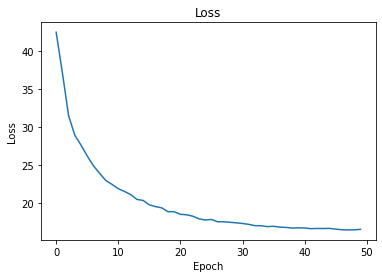

In [28]:
plt.title("Loss") 
plt.plot(total_loss)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Plotting train and test accuracies:

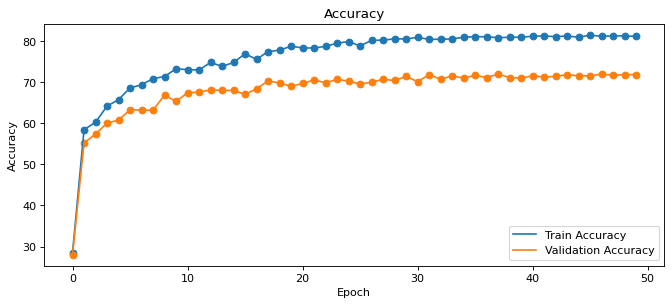

In [29]:
from matplotlib.pyplot import figure

figure(figsize=(10, 4), dpi=80)

plt.title("Accuracy") 
plt.plot(accuracies_train)
plt.plot(accuracies_test)

plt.scatter(list(range(epochs)), accuracies_train)
plt.scatter(list(range(epochs)), accuracies_test)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train Accuracy", "Validation Accuracy"], loc ="lower right")
plt.show()

## Saving the model so it can be loaded without training again:

In [144]:
import utils

path = os.path.join(os.getcwd(), 'model')
utils.save_model(model, path)

## Evaluation:

### Train accuracy:

In [30]:
accuracy = evaluate(model=model, test_loader=train_loader)

In [31]:
print(f'Train Accuracy: {accuracy:.2f}%')

Train Accuracy: 81.20%


### Validation accuracy:

In [32]:
accuracy = evaluate(model=model, test_loader=validation_loader)

In [33]:
print(f'Validation Accuracy: {accuracy:.2f}%')

Validation Accuracy: 71.88%


### Overall test accuracy:

In [34]:
accuracy = evaluate(model=model, test_loader=test_loader)

In [65]:
print(f'Overall Test Accuracy: {accuracy:.2f}%')

Overall Test Accuracy: 70.60%


In [113]:
import utils
import metrics

train_loader = DataLoader(dataset=train_dataset, batch_size=1)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

y_pred_train, y_truth_train = utils.get_y_pred_truth(model, train_loader)
y_pred_val, y_truth_val = utils.get_y_pred_truth(model, validation_loader)
y_pred_test, y_truth_test = utils.get_y_pred_truth(model, test_loader)

## Class accuracies (train set):

In [114]:
classes = ['pituitary_tumor', 'glioma_tumor', 'meningioma_tumor', 'no_tumor']

In [115]:
class_accuracies = {}
for i in range(NUM_OF_CLASSES):
    class_accuracies[classes[i]] = metrics.accuracy(torch.tensor(y_pred_train), torch.tensor(y_truth_train), i)

In [116]:
class_accuracies

{'pituitary_tumor': 0.737299771167048,
 'glioma_tumor': 0.7496510004653327,
 'meningioma_tumor': 0.7447988904299584,
 'no_tumor': 0.8456692913385827}

## Class Precision (train set):

In [117]:
class_precisions = {}
for i in range(NUM_OF_CLASSES):
    class_precisions[classes[i]] = metrics.precision(torch.tensor(y_pred_train), torch.tensor(y_truth_train), i)

In [118]:
class_precisions

{'pituitary_tumor': 0.872822299651568,
 'glioma_tumor': 0.8420074349442379,
 'meningioma_tumor': 0.7717391304347826,
 'no_tumor': 0.7857142857142857}

## Class Recall (train set):

In [119]:
class_recalls = {}
for i in range(NUM_OF_CLASSES):
    class_recalls[classes[i]] = metrics.recall(torch.tensor(y_pred_train), torch.tensor(y_truth_train), i)

In [120]:
class_recalls

{'pituitary_tumor': 0.5,
 'glioma_tumor': 0.5,
 'meningioma_tumor': 0.5,
 'no_tumor': 0.5}

## Class F Score (train set):

In [121]:
class_f_scores = {}
for i in range(NUM_OF_CLASSES):
    class_f_scores[classes[i]] = metrics.f_score(torch.tensor(y_pred_train), torch.tensor(y_truth_train), i)

In [122]:
class_f_scores

{'pituitary_tumor': 0.6357868020304569,
 'glioma_tumor': 0.6274238227146814,
 'meningioma_tumor': 0.6068376068376068,
 'no_tumor': 0.6111111111111112}

## Class accuracies (validation set):

In [123]:
classes = ['pituitary_tumor', 'glioma_tumor', 'meningioma_tumor', 'no_tumor']

In [124]:
class_accuracies = {}
for i in range(NUM_OF_CLASSES):
    class_accuracies[classes[i]] = metrics.accuracy(torch.tensor(y_pred_val), torch.tensor(y_truth_val), i)

In [125]:
class_accuracies

{'pituitary_tumor': 0.7157001414427157,
 'glioma_tumor': 0.7376093294460642,
 'meningioma_tumor': 0.7376093294460642,
 'no_tumor': 0.847571189279732}

## Class Precision (validation set):

In [126]:
class_precisions = {}
for i in range(NUM_OF_CLASSES):
    class_precisions[classes[i]] = metrics.precision(torch.tensor(y_pred_val), torch.tensor(y_truth_val), i)

In [127]:
class_precisions

{'pituitary_tumor': 0.8407960199004975,
 'glioma_tumor': 0.8222222222222222,
 'meningioma_tumor': 0.7055555555555556,
 'no_tumor': 0.6813186813186813}

## Class Recall (validation set):

In [128]:
class_recalls = {}
for i in range(NUM_OF_CLASSES):
    class_recalls[classes[i]] = metrics.recall(torch.tensor(y_pred_val), torch.tensor(y_truth_val), i)

In [129]:
class_recalls

{'pituitary_tumor': 0.5,
 'glioma_tumor': 0.5,
 'meningioma_tumor': 0.5,
 'no_tumor': 0.5}

## Class F Score (validation set):

In [130]:
class_f_scores = {}
for i in range(NUM_OF_CLASSES):
    class_f_scores[classes[i]] = metrics.f_score(torch.tensor(y_pred_val), torch.tensor(y_truth_val), i)

In [131]:
class_f_scores

{'pituitary_tumor': 0.62708719851577,
 'glioma_tumor': 0.6218487394957983,
 'meningioma_tumor': 0.5852534562211981,
 'no_tumor': 0.5767441860465117}

## Class accuracies (test set):

In [132]:
classes = ['pituitary_tumor', 'glioma_tumor', 'meningioma_tumor', 'no_tumor']

In [133]:
class_accuracies = {}
for i in range(NUM_OF_CLASSES):
    class_accuracies[classes[i]] = metrics.accuracy(torch.tensor(y_pred_test), torch.tensor(y_truth_test), i)

In [134]:
class_accuracies

{'pituitary_tumor': 0.7213352685050798,
 'glioma_tumor': 0.7384843982169391,
 'meningioma_tumor': 0.7213352685050798,
 'no_tumor': 0.8409475465313029}

## Class Precision (test set):

In [135]:
class_precisions = {}
for i in range(NUM_OF_CLASSES):
    class_precisions[classes[i]] = metrics.precision(torch.tensor(y_pred_test), torch.tensor(y_truth_test), i)

In [136]:
class_precisions

{'pituitary_tumor': 0.890625,
 'glioma_tumor': 0.7329545454545454,
 'meningioma_tumor': 0.6510416666666666,
 'no_tumor': 0.7659574468085106}

## Class Recall (test set):

In [137]:
class_recalls = {}
for i in range(NUM_OF_CLASSES):
    class_recalls[classes[i]] = metrics.recall(torch.tensor(y_pred_test), torch.tensor(y_truth_test), i)

In [138]:
class_recalls

{'pituitary_tumor': 0.5,
 'glioma_tumor': 0.5,
 'meningioma_tumor': 0.5,
 'no_tumor': 0.5}

## Class F Score (test set):

In [139]:
class_f_scores = {}
for i in range(NUM_OF_CLASSES):
    class_f_scores[classes[i]] = metrics.f_score(torch.tensor(y_pred_test), torch.tensor(y_truth_test), i)

In [140]:
class_f_scores

{'pituitary_tumor': 0.6404494382022472,
 'glioma_tumor': 0.5944700460829493,
 'meningioma_tumor': 0.5656108597285068,
 'no_tumor': 0.6050420168067226}